# Waveform analysis

## 1. Load data

In [1]:
import signal_ana as ana
import pandas as pd
%load_ext autoreload
%autoreload 2

/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
use_wf = True
use_lpc = False
use_amp = False

In [3]:
# Load the signals
df = ana.load_signals('features_30.h5')

In [4]:
df.head()
# decimated_vlp_waveform

,time,waveform,lpc_coeff,amplitude
0,2019-05-27 18:16:37+00:00,"[3.72132730069, -51.1812948272, -104.97754986,...","[1.0, -2.18162593255, 2.49176485988, -1.993432...","[0.390425590627, 0.366654576689, 0.33067666624..."
1,2019-05-27 17:31:45+00:00,"[267.286223554, 213.095748702, 156.62064283, 9...","[1.0, -1.91957893956, 1.75126094982, -1.247919...","[0.304056059595, 0.328030528642, 0.44393763535..."
2,2019-05-27 17:17:41+00:00,"[-150.572442193, -248.678406427, -332.00272918...","[1.0, -2.23007592873, 2.50516095499, -2.071459...","[0.661311999342, 0.584146916956, 0.42782305131..."
3,2019-05-27 19:23:49+00:00,"[-220.99252159, -347.395354446, -449.371607879...","[1.0, -2.32914670106, 2.68123537773, -2.092240...","[0.382224472907, 0.586558602969, 0.38374742891..."
4,2019-05-27 20:41:11+00:00,"[157.167620135, 286.219708967, 395.840778773, ...","[1.0, -2.38909167965, 2.78044991558, -2.351892...","[0.430395495412, 0.381969445864, 0.41658439725..."


In [5]:
# Scale to zero mean and unit variance
ana.normalize(df, 'waveform')
ana.normalize(df, 'lpc_coeff')
ana.normalize(df, 'amplitude')

In [6]:
# Exclude the eruption days
eruption_days = [ ('2019-07-03', '2019-07-04'), ('2019-08-28', '2019-08-29'), ('2019-08-29', '2019-08-30')]
df = ana.exclude_days(df, eruption_days)

In [7]:
# Select a test period
df_test = ana.test_period(df)

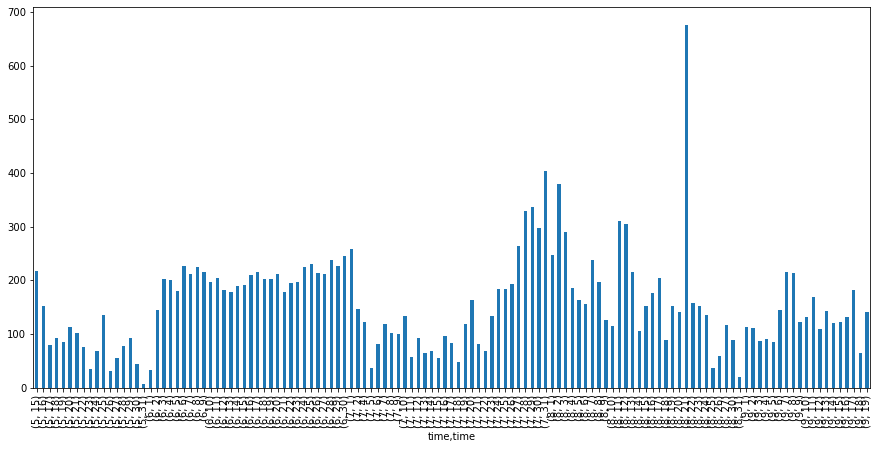

In [8]:
# Frequency of signals per day
ana.plot_freq(df)

In [9]:
features = ana.get_features(df, wf = use_wf, lpc=use_lpc, amp=use_amp)

## 2. Clustering with Self Organizing Maps

### Bayesian optimization of quantization and topological error

In [10]:
# Train som

size_x = 25
size_y = 25
niter = 59000 #10000
sigma = 2.2 # #0.3
learning_rate= .013 #.5
pca=False
random_seed = 2

"""
size_x = 10
size_y = 6
niter = 50000 #20000 #10000
sigma = 1.23 # #0.3
learning_rate= .04 #.5
pca=False
random_seed = 2
"""

'\nsize_x = 10\nsize_y = 6\nniter = 50000 #20000 #10000\nsigma = 1.23 # #0.3\nlearning_rate= .04 #.5\npca=False\nrandom_seed = 2\n'

In [ ]:
from skopt.space import Real, Categorical, Integer

# Skopt dimensions
skopt_dims = [       
    Real(        low=1e-2, high=1,     prior='log-uniform', name='learning_rate'     ),
    Real(        low=.1,    high=5,                         name='sigma'     ),
    Real(     low=1e2,    high=1e5,   prior='log-uniform', name='niter'       )
]

# Initial parameters
init_param = {'learning_rate':0.5, 'sigma':0.3, 'niter' : 10000}

search_result = ana.optimize(skopt_dims, init_param, features, size_x, size_y,
                             num_calls=20, pca = pca, random_seed = random_seed)

In [11]:
som = ana.run_som(features, size_x, size_y, niter = niter, sigma=sigma, learning_rate=learning_rate, 
                  pca=pca, plot_error = False, random_seed = random_seed)

### Visualize the nodes

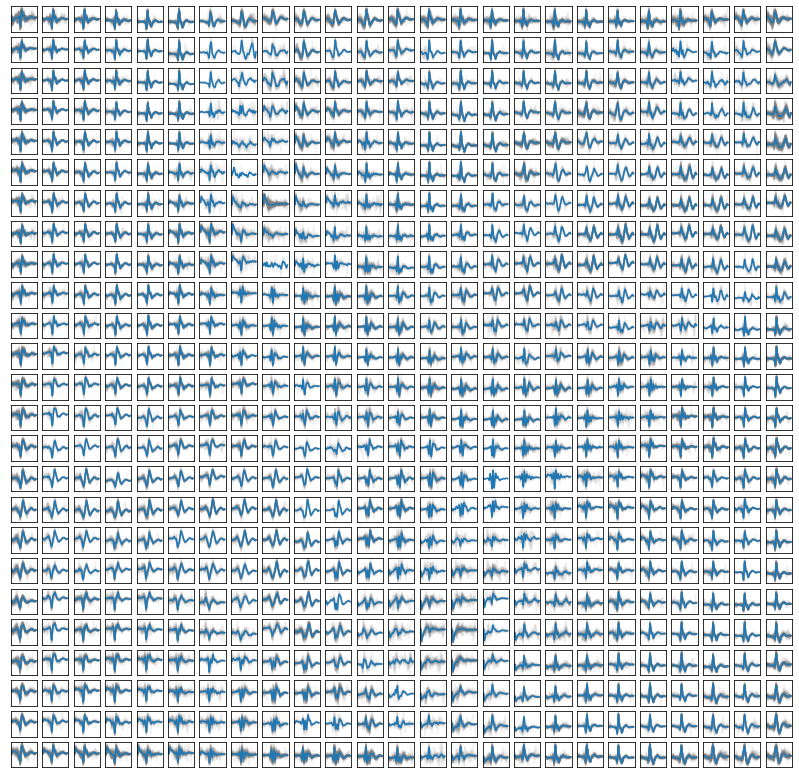

In [12]:
ana.plot_waveforms(features, som, size_x, size_y )

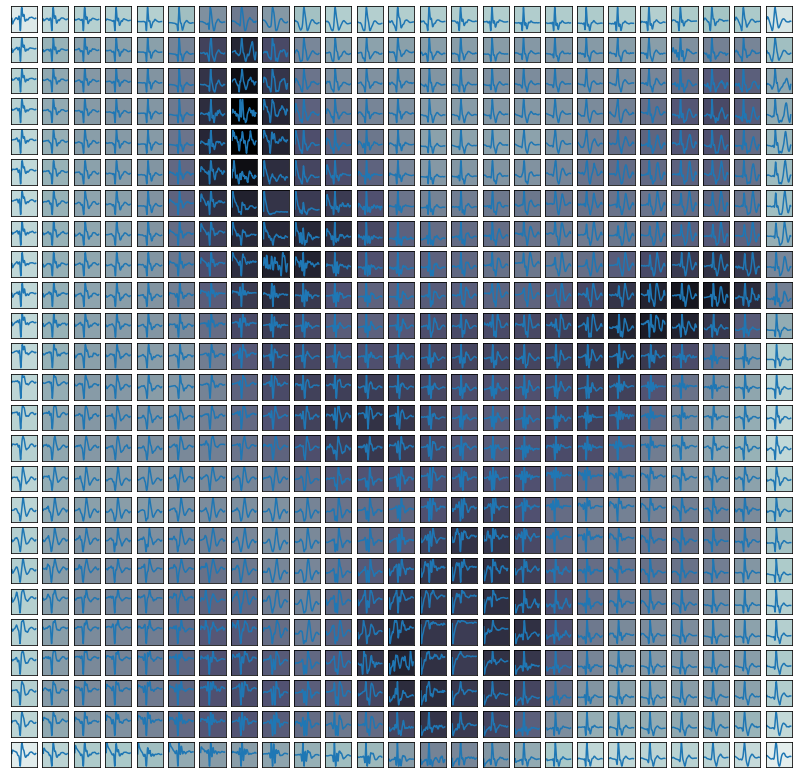

In [13]:
ana.plot_dmap(features, som, size_x, size_y)

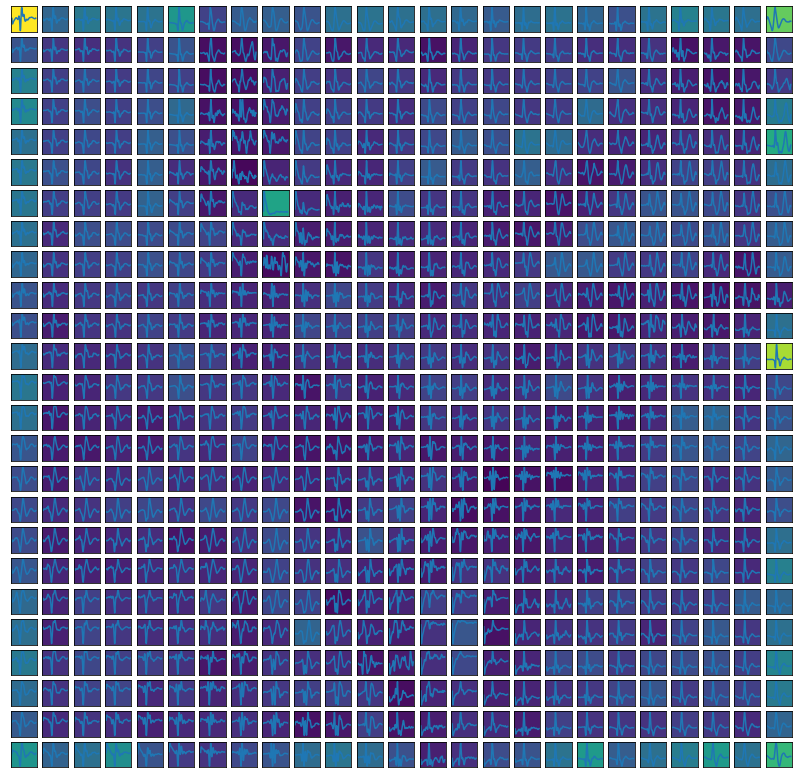

In [14]:
ana.plot_density(features, som, size_x, size_y )

### Time evolution of the nodes

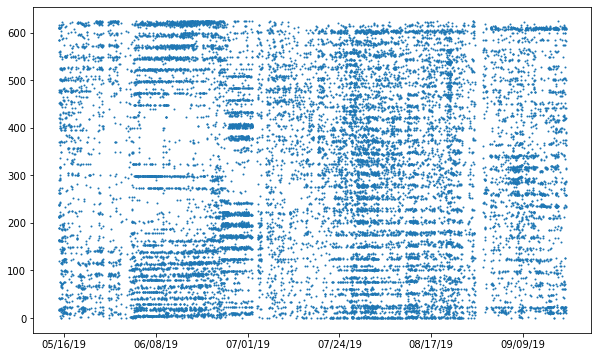

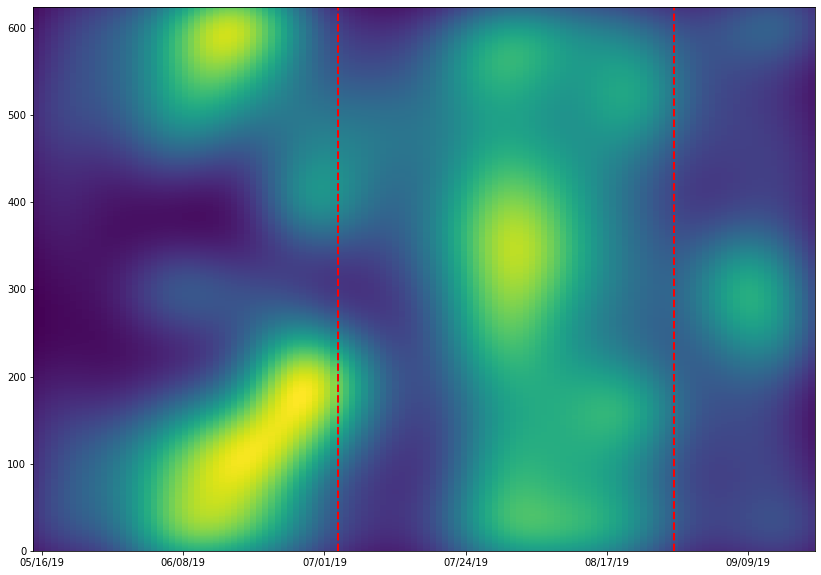

In [15]:
ana.feat_to_cluster(df, som, size_x, size_y, wf = use_wf, lpc = use_lpc, amp = use_amp)
ana.plot_evo(df, som, size_x, size_y)

### Clustering of the nodes with kmeans

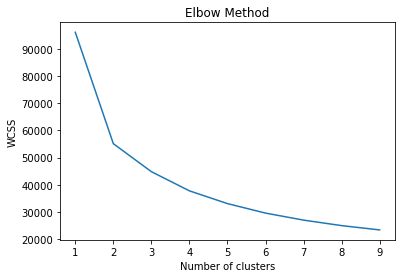

In [18]:
# Elbow method to check the number of clusters
ana.kmeans_som(som, features, size_x, size_y, n_clusters=4, run_elbow=True)

In [123]:
n_clusters = 4

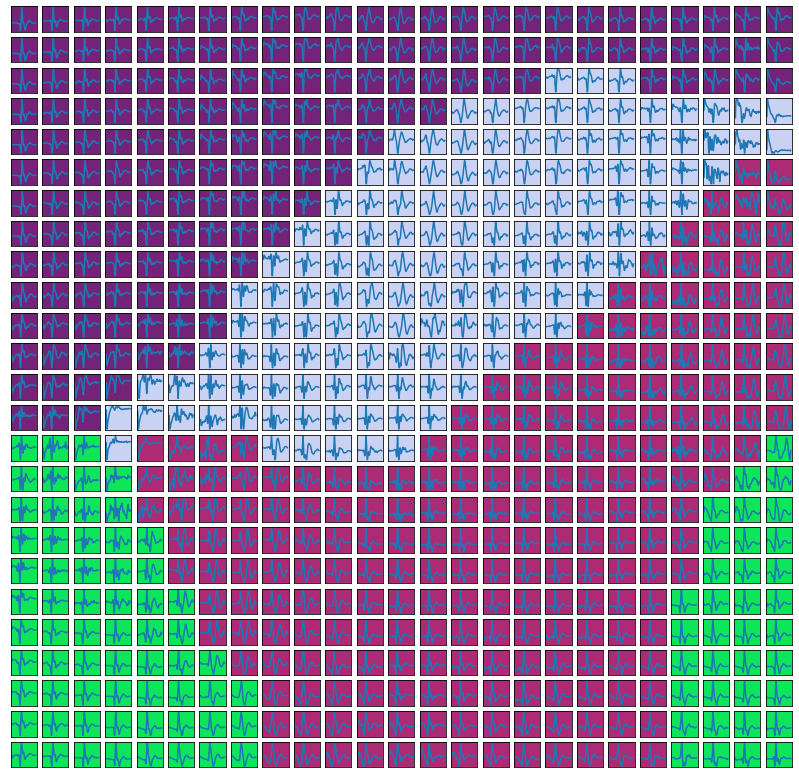

In [19]:
clusters = ana.kmeans_som(som, features, size_x, size_y, n_clusters=n_clusters)

In [21]:
ana.feat_to_cluster(df, som, size_x, size_y, wf = use_wf, lpc = use_lpc, amp = use_amp)

In [25]:
ana.som_to_kmeans_cluster(df, clusters)

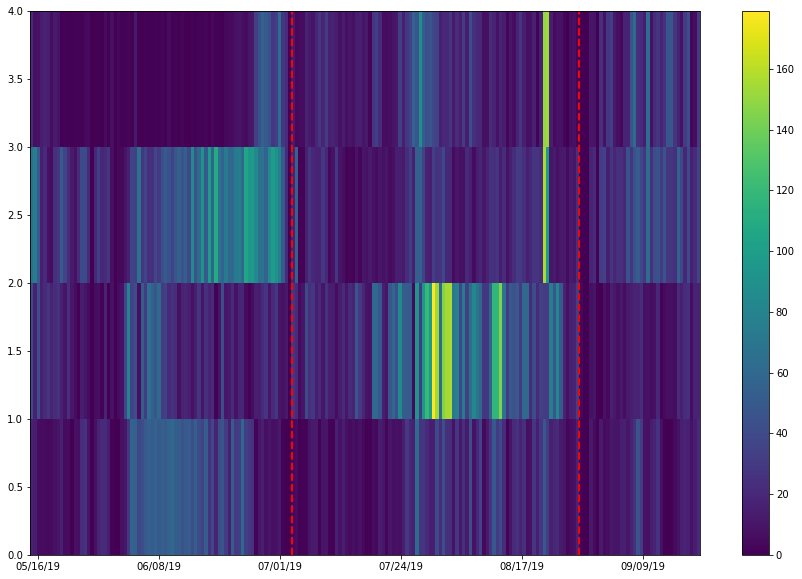

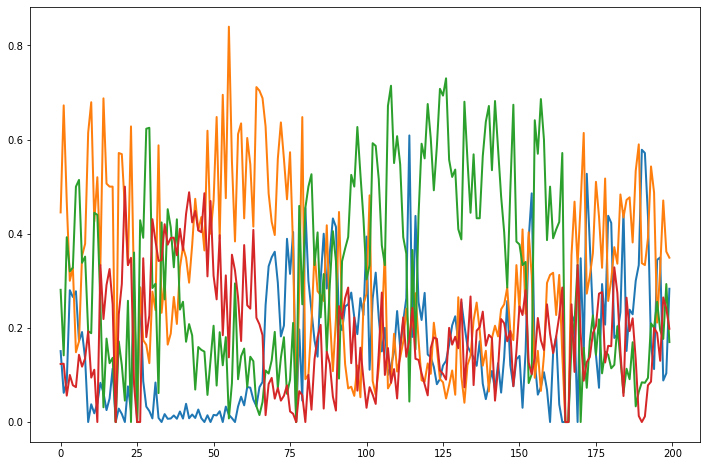

In [122]:
ana.plot_hist2d(df, 'cluster_som_kmeans', n_clusters)

## Clustering with K-means with T-SNE visualization

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 19748 samples in 0.403s...
[t-SNE] Computed neighbors for 19748 samples in 118.054s...
[t-SNE] Computed conditional probabilities for sample 1000 / 19748
[t-SNE] Computed conditional probabilities for sample 2000 / 19748
[t-SNE] Computed conditional probabilities for sample 3000 / 19748
[t-SNE] Computed conditional probabilities for sample 4000 / 19748
[t-SNE] Computed conditional probabilities for sample 5000 / 19748
[t-SNE] Computed conditional probabilities for sample 6000 / 19748
[t-SNE] Computed conditional probabilities for sample 7000 / 19748
[t-SNE] Computed conditional probabilities for sample 8000 / 19748
[t-SNE] Computed conditional probabilities for sample 9000 / 19748
[t-SNE] Computed conditional probabilities for sample 10000 / 19748
[t-SNE] Computed conditional probabilities for sample 11000 / 19748
[t-SNE] Computed conditional probabilities for sample 12000 / 19748
[t-SNE] Computed conditional probabilities for 

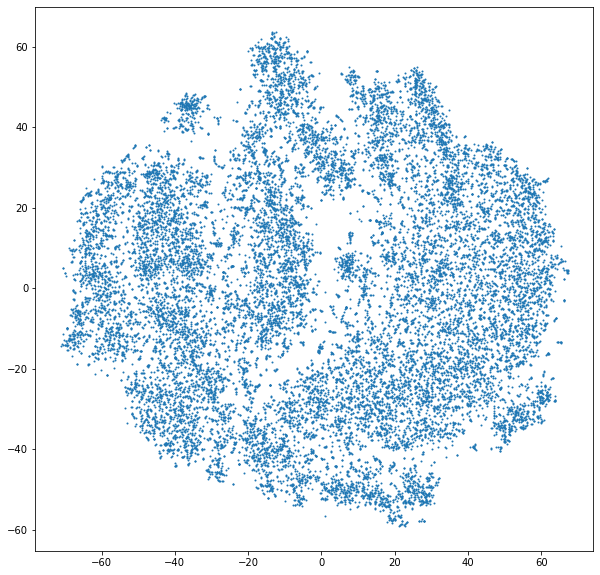

In [127]:
tsne_x, tsne_y = ana.run_tsne(features)
df['tsne_x'] = tsne_x
df['tsne_y'] = tsne_y

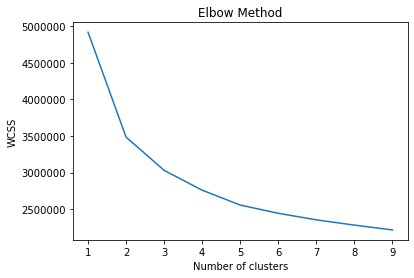

In [132]:
# Run elbow method
max_cls = 10
ana.elbow(max_cls, features)

In [133]:
# Run kmeans
n_cluster = 4
df['kmeans'] = ana.run_kmeans(features, n_cluster)

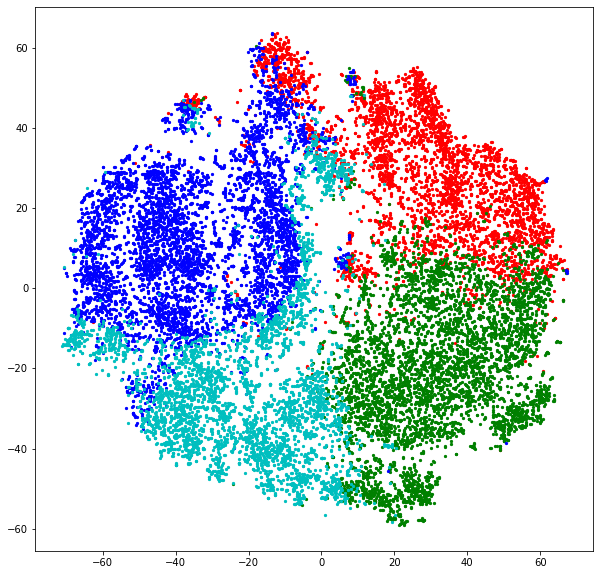

r


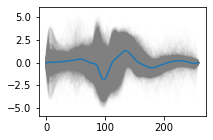

g


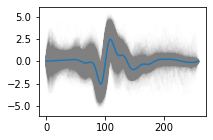

b


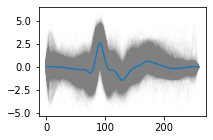

c


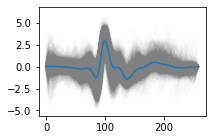

In [146]:
ana.plot_kmeans_tsne(df, 'kmeans', n_clusters)